<a href="https://colab.research.google.com/github/masfworld/sparkstreaming_datahack_webinar/blob/master/SparkStreaming_Datahack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spark Streaming


<a href="https://datahack.es">
  <img src="https://www.datahack.es/wp-content/uploads/2019/10/Todo_vertical.png" Big Data Spain"" width="40%">
  
  
**Author**:
miguel.sotomayor@sidesna.es\
https://www.linkedin.com/in/miguelsotomayorf/ \
https://github.com/masfworld





# Prerrequisites

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

# For maps
!pip install matplotlib
!pip install pyproj==1.9.6
!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
#TODO Maps

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import pandas as pd
cities = pd.read_csv('data/california_cities.csv')

# Extract the data we're interested in
lat = cities['latd'].values
lon = cities['longd'].values
population = cities['population_total'].values
area = cities['area_total_km2'].valuesfrom mpl_toolkits.basemap import Basemap

NameError: ignored

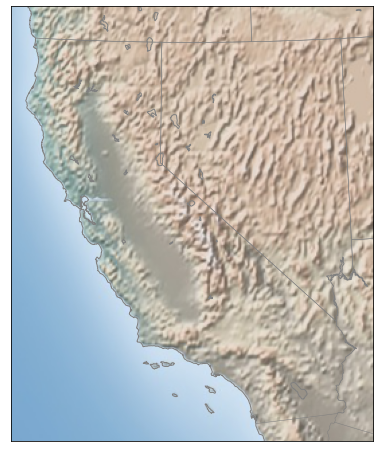

In [60]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In [2]:
!wget -q https://github.com/masfworld/datahack_docker/raw/master/zeppelin/libs/libs-kafka.zip --directory-prefix=/content/spark-2.4.5-bin-hadoop2.7/jars/
!unzip -n /content/spark-2.4.5-bin-hadoop2.7/jars/libs-kafka.zip -d /content/spark-2.4.5-bin-hadoop2.7/jars/
!ls /content/spark-2.4.5-bin-hadoop2.7/jars/*kafka*

Archive:  /content/spark-2.4.5-bin-hadoop2.7/jars/libs-kafka.zip
/content/spark-2.4.5-bin-hadoop2.7/jars/kafka-clients-2.0.0.jar
/content/spark-2.4.5-bin-hadoop2.7/jars/libs-kafka.zip
/content/spark-2.4.5-bin-hadoop2.7/jars/libs-kafka.zip.1
/content/spark-2.4.5-bin-hadoop2.7/jars/libs-kafka.zip.2
/content/spark-2.4.5-bin-hadoop2.7/jars/spark-sql-kafka-0-10_2.11-2.4.5.jar


Define the environment (Java & Spark homes)

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["PYSPARK_SUBMIT_ARGS"] = ""

Starting Spark Session and print the version

In [4]:
import findspark
findspark.add_packages(["org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5"])
findspark.add_jars(["/content/spark-2.4.5-bin-hadoop2.7/jars/kafka-clients-2.0.0.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/lz4-java-1.4.1-jar","/content/spark-2.4.5-bin-hadoop2.7/jars/scala-library-2.11.12.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/slf4j-api-1.7.25.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/snappy-java-1.1.7.1.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/spark-sql-kafka-0-10_2.11-2.4.5.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/spark-tags_2.11-2.4.5.jar","/content/spark-2.4.5-bin-hadoop2.7/jars/unused-1.0.0.jar"])
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession

# create the session
spark = SparkSession \
        .builder \
        .master("local[*]") \
        .config("spark.ui.port", "4050") \
        .getOrCreate()

spark.version

'2.4.5'

In [5]:
spark

Creating ngrok tunnel to allow Spark UI


In [6]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-04-26 16:01:59--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.95.144.123, 34.202.14.95, 52.7.103.227, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.95.144.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  13.13M  27.5MB/s    in 0.5s    

2020-04-26 16:02:00 (27.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://c7d0b522.ngrok.io


# Streaming from a directory

In [7]:
!head /content/sample_data/california_housing_train.csv

"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
-114.570000,33.570000,20.000000,1454.000000,326.000000,624.000000,262.000000,1.925000,65500.000000
-114.580000,33.630000,29.000000,1387.000000,236.000000,671.000000,239.000000,3.343800,74000.000000
-114.580000,33.610000,25.000000,2907.000000,680.000000,1841.000000,633.000000,2.676800,82400.000000
-114.590000,34.830000,41.000000,812.000000,168.000000,375.000000,158.000000,1.708300,48500.000000
-114.590000,33.610000,34.000000,4789.000000,1175.000000,3134.000000

In [13]:
!mkdir -p /content/california_housing
!cp /content/sample_data/california_housing_train.csv /content/california_housing/
!ls /content/california_housing/

california_housing_train.csv


In [0]:
from pyspark.sql.types import StructType

# Read all the csv files written atomically in a directory
housingSchema = StructType()\
.add("longitude", "double")\
.add("latitude", "double")\
.add("housing_median_age", "double")\
.add("total_rooms", "double")\
.add("total_bedrooms", "double")\
.add("population", "double")\
.add("households", "double")\
.add("median_income", "double")\
.add("median_house_value", "double")

housing_df = spark \
    .readStream \
    .option("sep", ",") \
    .option("header", "true") \
    .schema(housingSchema) \
    .csv("/content/california_housing/")  


In [0]:
from pyspark.sql.functions import col, avg

housing_avg = housing_df.agg(avg(col('total_bedrooms')))

In [20]:
housing_avg_query = housing_avg \
                      .writeStream \
                      .outputMode("complete") \
                      .format("memory") \
                      .queryName("housing_avg")

housing_avg_query.start()

In [21]:
spark.sql("select * from housing_avg").show()

+-------------------+
|avg(total_bedrooms)|
+-------------------+
|  539.4108235294118|
+-------------------+



In [0]:
!cp /content/sample_data/california_housing_test.csv /content/california_housing/

In [23]:
spark.sql("select * from housing_avg").show()

+-------------------+
|avg(total_bedrooms)|
+-------------------+
|           537.9918|
+-------------------+



In [25]:
housing_avg_query.stop()

AttributeError: ignored

# Streaming From Kafka

In [0]:
kafka_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "3.91.75.32:9092") \
  .option("subscribe", "test") \
  .load()

In [0]:
kafka_df \
  .writeStream \
  .outputMode("append") \
  .format("memory") \
  .queryName("test_kafka_datahack_3") \
  .start()

In [0]:
spark.sql("select * from test_kafka_datahack_3").show()

+----+--------------------+-----+---------+------+--------------------+-------------+
| key|               value|topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-----+---------+------+--------------------+-------------+
|null|[65 73 74 6F 20 6...| test|        0|     2|2020-04-22 15:37:...|            0|
+----+--------------------+-----+---------+------+--------------------+-------------+



In [0]:
# TODO: Convert to Python
spark.streams.active.foreach(query => println(s"${query.id} ${query.name}\n${query.status}"))
spark.streams.active.foreach(query => println(s"${query.explain}"))
spark.streams.active.foreach(query => query.stop)